### Multivariate Stock Price Prediction

In this notebook we are going to do a multivariate stock price prediction based on the:

1. open price
2. close price
3. high price
4. low price

For coca-cola and pepsi using the dataset that was obtained from kaggle:

https://www.kaggle.com/datasets/prathamjyotsingh/pepsi-vs-coca-cola

First we are going to import all the packages that we are going to use in this notebook.

In [48]:

import os
import torch
import random
import time
from torch.nn import functional as F
from torch import nn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset


print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.3.0
numpy:  1.26.4
pandas:  2.1.4


Next we are going to setup the `Seed` for reproducivity in this notebook.

In [5]:
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

Since we will be using pytorch, we are going to check if we have `gpu` so that we can utilize that for faster mathematical computations.

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In the next code cells we are going to load our dataset and rename columns according to what we want before we medge the 2 dataframes.

In [11]:
ko_df = pd.read_csv('KO_stock_price.csv')
pep_df = pd.read_csv('PEP_stock_price.csv')

In [13]:
ko_columns = {
    "Open Price": "ko_open", "High Price": "ko_high",
    "Low Price": "ko_low",	"Close Price": "ko_close", 
    "Volume": "ko_volume"
}
pep_columns = {
    "Open Price": "pep_open", "High Price": "pep_high",
    "Low Price": "pep_low",	"Close Price": "pep_close", 
    "Volume": "pep_volume"
}

In [15]:
ko_df.rename(columns=ko_columns, inplace=True)
ko_df.drop(columns=['Date'], inplace=True)
pep_df.rename(columns=pep_columns, inplace=True)

In [17]:
ko_df.head(2)

,ko_open,ko_high,ko_low,ko_close,ko_volume
0,58.25,59.38,57.88,59.00,4212600.0
1,58.63,58.94,57.31,57.75,3226800.0


In [19]:
pep_df.head(2)

,Date,pep_open,pep_high,pep_low,pep_close,pep_volume
0,1999-11-01,34.44,34.56,33.56,33.56,3635000.0
1,1999-11-02,33.63,34.31,33.56,33.69,2682900.0


In [21]:
dataframe = pd.concat([pep_df, ko_df], axis=1).rename(columns={"Date": "date"})
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe.index = dataframe.date
dataframe.head(2)

,date,pep_open,pep_high,pep_low,pep_close,pep_volume,ko_open,ko_high,ko_low,ko_close,ko_volume
date,,,,,,,,,,,
1999-11-01,1999-11-01,34.44,34.56,33.56,33.56,3635000.0,58.25,59.38,57.88,59.00,4212600.0
1999-11-02,1999-11-02,33.63,34.31,33.56,33.69,2682900.0,58.63,58.94,57.31,57.75,3226800.0


### Data Visualization

In this section we are going to visualize the data that we have. First we are going to visualize the coke and pep close price.

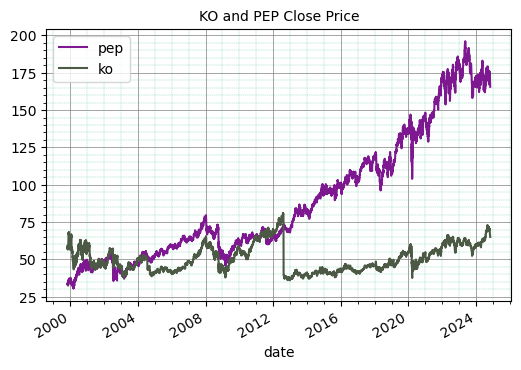

In [24]:
plt.figure(figsize=(6, 4))
pep_close = dataframe['pep_close']
ko_close = dataframe['ko_close']
pep_close.plot(label="pep", color="#7E1891")
ko_close.plot(label="ko", color="#4B5945")

plt.legend()
plt.minorticks_on()
plt.title("KO and PEP Close Price", fontsize=10)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Next we will visualize the open price of these two beverages.

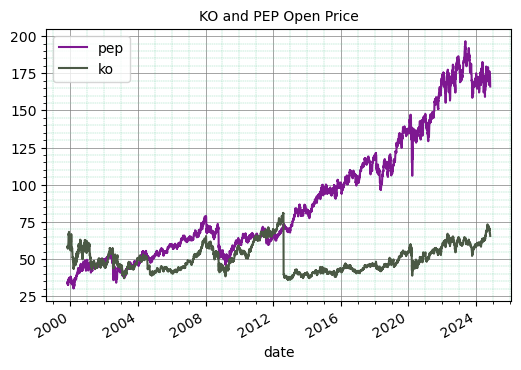

In [27]:
plt.figure(figsize=(6, 4))
pep_open = dataframe['pep_open']
ko_open = dataframe['ko_open']
pep_open.plot(label="pep", color="#7E1891")
ko_open.plot(label="ko", color="#4B5945")

plt.title("KO and PEP Open Price", fontsize=10)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Next we will check the close price of these two drinks.

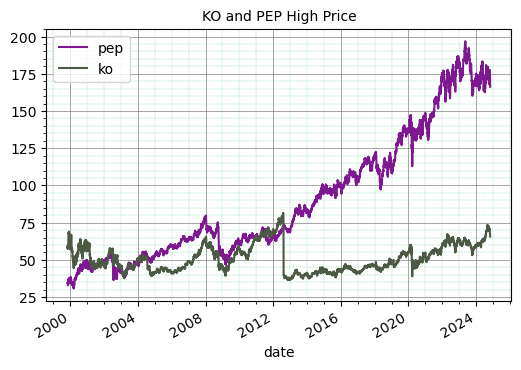

In [30]:
plt.figure(figsize=(6, 4))
pep_high = dataframe['pep_high']
ko_high = dataframe['ko_high']
pep_high.plot(label="pep", color="#7E1891")
ko_high.plot(label="ko", color="#4B5945")

plt.title("KO and PEP High Price", fontsize=10)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Next we are going to visualize the `low` prices.

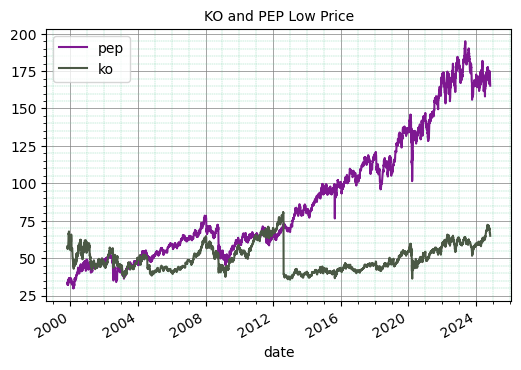

In [33]:
plt.figure(figsize=(6, 4))
pep_low = dataframe['pep_low']
ko_low = dataframe['ko_low']
pep_low.plot(label="pep", color="#7E1891")
ko_low.plot(label="ko", color="#4B5945")

plt.title("KO and PEP Low Price", fontsize=10)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

In the following code cell we are going to create a new data frame with all the data that we want which include:

1. pep open price
2. pep close price
3. pep high price
4. pep low price
5. ko high price
6. ko low price
7. ko open price
8. ko close price

> We are going to create another column called `seconds` that will map to timestamp of the index column which is the date column. We are going to use these column to create 4 more columns which are:

1. day cos
2. day sin
3. year cos
4. year sin

In [37]:
new_df = pd.DataFrame({
    'pep_close': pep_close, 
    'ko_close': ko_close,
    'pep_open': pep_open, 
    'ko_open': ko_open, 
    'pep_low': pep_low,
    'ko_low': ko_low, 
    'pep_high': pep_high, 
    'ko_high': ko_high, 
})
new_df['seconds'] = new_df.index.map(pd.Timestamp.timestamp)
new_df.head(2)

,pep_close,ko_close,pep_open,ko_open,pep_low,ko_low,pep_high,ko_high,seconds
date,,,,,,,,,
1999-11-01,33.56,59.00,34.44,58.25,33.56,57.88,34.56,59.38,941414400.0
1999-11-02,33.69,57.75,33.63,58.63,33.56,57.31,34.31,58.94,941500800.0


In [39]:
day = 60 * 60 * 24
year = 365.2425 * day

new_df['day_sin'] = np.sin(new_df['seconds'] * (2* np.pi / day))
new_df['day_cos'] = np.cos(new_df['seconds'] * (2 * np.pi / day))
new_df['year_sin'] = np.sin(new_df['seconds'] * (2 * np.pi / year))
new_df['year_cos'] = np.cos(new_df['seconds'] * (2 * np.pi / year))
new_df.drop(columns=["seconds"], inplace=True)
new_df.head(2)

,pep_close,ko_close,pep_open,ko_open,pep_low,ko_low,pep_high,ko_high,day_sin,day_cos,year_sin,year_cos
date,,,,,,,,,,,,
1999-11-01,33.56,59.00,34.44,58.25,33.56,57.88,34.56,59.38,-5.738295e-12,1.0,-0.869456,0.494010
1999-11-02,33.69,57.75,33.63,58.63,33.56,57.31,34.31,58.94,-1.439756e-12,1.0,-0.860829,0.508894


So we are going to predict temperature and pressure based on the previously recorded temperatures and pressure. We are going to set the default `window_size` to be 12. This means that we will use the previous 12 values to get the current value.

In [42]:
def dataframe_to_X_y(dataframe, window_size=12):
    values = dataframe.to_numpy()
    X = []
    y = []
    for i in range(len(values)-window_size):
        row = [r for r in values[i:i+window_size]]
        X.append(row)
        label = [values[i+window_size][0], values[i+window_size][1],
                 values[i+window_size][2], values[i+window_size][3],
                 values[i+window_size][4], values[i+window_size][5],
                 values[i+window_size][6],  values[i+window_size][7]
                ]
        y.append(label)
    return np.array(X), np.array(y)
X, y = dataframe_to_X_y(new_df)
X.shape, y.shape

((6280, 12, 12), (6280, 8))

Next we are going then to splits our sets into 3 subsets which are:

1. train
2. test
3. validation

In [90]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.10, shuffle=False) ## this is a time series prediction
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, shuffle=False) ## this is a time series prediction

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((5086, 12, 12), (5086, 8), (628, 12, 12), (628, 8), (566, 12, 12), (566, 8))

Next we are going to check how many examples are found in each set.

In [93]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(X_train):,}"],
    ["TESTING", f"{len(X_test):,}"],
    ["VALIDATION", f"{len(X_val):,}"],
    ["TOTAL", f"{len(X_train) + len(X_test) + len(X_val):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+-------+
| Set        | Total |
+------------+-------+
| TRAINING   | 5,086 |
| TESTING    |   628 |
| VALIDATION |   566 |
| TOTAL      | 6,280 |
+------------+-------+


In [95]:
new_df.head(1)

,pep_close,ko_close,pep_open,ko_open,pep_low,ko_low,pep_high,ko_high,day_sin,day_cos,year_sin,year_cos
date,,,,,,,,,,,,
1999-11-01,33.56,59.0,34.44,58.25,33.56,57.88,34.56,59.38,-5.738295e-12,1.0,-0.869456,0.49401


Some of our features needs to be scalled. For that we are going to create a scaler for each of the columns that requires scaling. We are going to use the `StandardScaler()` to scale these features.

In [98]:
pep_high_scaler = StandardScaler()
pep_low_scaler = StandardScaler()
pep_close_scaler = StandardScaler()
pep_open_scaler = StandardScaler()

ko_high_scaler = StandardScaler()
ko_low_scaler = StandardScaler()
ko_close_scaler = StandardScaler()
ko_open_scaler = StandardScaler()

Nexxt we are going to create two functions which are:

1. `preprocess_features` - which preprocesses all the features by scaling them using `StandardScaler`
2. `preprocess_output` - which will scale all the labels again using the `StandardScaler`

In [101]:
def preprocess_features(X):
    pep_close = X[:, :, 0]
    ko_close = X[:, :, 1]
    pep_open = X[:, :, 2]
    ko_open = X[:, :, 3]
    pep_low = X[:, :, 4]
    ko_low = X[:, :, 5]
    pep_high = X[:, :, 6]
    ko_high = X[:, :, 7]

    X[:, :, 0] = pep_close_scaler.fit_transform(pep_close)
    X[:, :, 1] = ko_close_scaler.fit_transform(ko_close)
    X[:, :, 2] = pep_open_scaler.fit_transform(pep_open)
    X[:, :, 3] = ko_open_scaler.fit_transform(ko_open)
    X[:, :, 4] = pep_low_scaler.fit_transform(pep_low)
    X[:, :, 5] = ko_low_scaler.fit_transform(ko_low)
    X[:, :, 6] = pep_high_scaler.fit_transform(pep_high)
    X[:, :, 7] = ko_high_scaler.fit_transform(ko_high)
    return X

def preprocess_output(y):
    pep_close = y[:, 0].reshape(-1, 1)
    ko_close = y[:, 1].reshape(-1, 1)
    pep_open = y[:, 2].reshape(-1, 1)
    ko_open = y[:, 3].reshape(-1, 1)
    pep_low = y[:, 4].reshape(-1, 1)
    ko_low = y[:, 5].reshape(-1, 1)
    pep_high = y[:, 6].reshape(-1, 1)
    ko_high = y[:, 7].reshape(-1, 1)

    y[:, 0] = pep_close_scaler.fit_transform(pep_close).flatten()
    y[:, 1] = ko_close_scaler.fit_transform(ko_close).flatten()
    y[:, 2] = pep_open_scaler.fit_transform(pep_open).flatten()
    y[:, 3] = ko_open_scaler.fit_transform(ko_open).flatten()
    y[:, 4] = pep_low_scaler.fit_transform(pep_low).flatten()
    y[:, 5] = ko_low_scaler.fit_transform(ko_low).flatten()
    y[:, 6] = pep_high_scaler.fit_transform(pep_high).flatten()
    y[:, 7] = ko_high_scaler.fit_transform(ko_high).flatten()
    return y

Let's check one of our features before processed.

In [104]:
print([ str(i) for i in X_train[0][0]])

['33.56', '59.0', '34.44', '58.25', '33.56', '57.88', '34.56', '59.38', '-5.738294923185545e-12', '1.0', '-0.8694560522513044', '0.49401029665744534']


In [106]:
preprocess_features(X_train)
preprocess_features(X_test)
preprocess_features(X_val)
print()

Let's check it after being preprocessed.

In [109]:
print([ str(i) for i in X_train[0][0]])

['-1.5126498987598371', '1.160642700162021', '-1.4763288396483463', '1.079210709943594', '-1.495211782778359', '1.0905427891699642', '-1.4888133075314263', '1.153117536628549', '-5.738294923185545e-12', '1.0', '-0.8694560522513044', '0.49401029665744534']


Let's check for the labels as well.

In [112]:
print([ str(i) for i in y_train[0]])

['34.13', '59.94', '33.63', '58.69', '33.5', '58.5', '34.63', '60.0']


In [114]:
preprocess_output(y_train)
preprocess_output(y_test)
preprocess_output(y_val)
print()

Let's check the preprocessed labels.

In [117]:
print([ str(i) for i in y_train[0]])

['-1.4916548666060498', '1.2688650673170145', '-1.5088051577671144', '1.1299769869409846', '-1.4987048526860633', '1.162411630314409', '-1.4872216446392963', '1.2240890411825374']


Next we are going to convert our features and labels into pytorch tensors.

In [120]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In the next code cell we are going to create teh `StockPriceFocastingDataset` which takes in the features and labels. We are going to use this class to create a new dataset based on the splitted examples and later on we will batch them with a specific batch using the `DataLoader`.

In [123]:
class StockPriceFocastingDataset(Dataset):
    def __init__(self, X, y):
        super(StockPriceFocastingDataset, self).__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.y[index], self.X[index]

In [125]:
train_dataset = StockPriceFocastingDataset(X_train, y_train)
test_dataset = StockPriceFocastingDataset(X_test, y_test)
val_dataset = StockPriceFocastingDataset(X_val, y_val)

In [127]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's iterarate over a single example batch so that we can check if our features and labels are in right shape.

In [130]:
for label, feature in train_loader:
    break

In [132]:
label[:2]

tensor([[-0.4129,  2.1821, -0.4035,  2.2508, -0.4059,  2.2224, -0.4156,  2.2129],
        [ 2.2595,  0.2139,  2.1764,  0.1281,  2.1900,  0.1373,  2.2413,  0.2112]])

In [134]:
feature[0][:2]

tensor([[-4.6469e-01,  1.8966e+00, -4.8665e-01,  1.9703e+00, -4.8665e-01,
          1.8551e+00, -4.8119e-01,  1.9099e+00, -5.3204e-12,  1.0000e+00,
         -9.9748e-01,  7.0913e-02],
        [-4.4784e-01,  1.9554e+00, -4.4770e-01,  2.0327e+00, -4.4368e-01,
          1.9646e+00, -4.4504e-01,  1.9683e+00, -1.0219e-12,  1.0000e+00,
         -9.9612e-01,  8.8061e-02]])

### Model

We are going to create a model `StockPricesModelBiLSTM` in the following code cell and we will initialize it.

In [137]:
class StockPricesModelBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5, bidirectional=False):
        super(StockPricesModelBiLSTM, self).__init__()
    
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 8),
            nn.ReLU(inplace=False),
            nn.Linear(8, output_size),
        )
        self.dropout = nn.Dropout(dropout/3)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.out(out[:, -1, :])
        return out
        
INPUT_DIM = feature.size()[1]
HIDDEN_DIM = 64
OUTPUT_DIM = label.size()[1]
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.75

model = StockPricesModelBiLSTM(
    INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, 
    num_layers = N_LAYERS, 
    bidirectional = BIDIRECTIONAL, 
    dropout = DROPOUT
).to(device)
model

StockPricesModelBiLSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.75, bidirectional=True)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In the next code cell we are going to count the model's parameters.

In [140]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["model", *count_trainable_params(model)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| model |      140,368 |          140,368 |
+-------+--------------+------------------+


Next we are going to create the optimizer and criterion. For the optimizer we are going to use `Adam` and for the loss function we are going to use the `Mean Squared Loss`.

In [143]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

In the following code cell we are going to write our `train` and `evaluate` functions.

In [152]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train(True)
    for y, X in iterator:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss =  0
  model.eval()
  with torch.no_grad():
    for y, X in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X)
      loss = criterion(predictions, y)
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)

In the following code cell we will create the history class that will keep intrack of the model's training history interms of epoch training time and loss.

In [155]:
class History:
    def __init__(self):
        self.train_losses = list()
        self.epoch_train_time = list()
        self.val_losses = list()
    def add(self, train_loss:float, val_loss:float, elt:float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch_train_time.append(elt)

Next we are going to create a function called `run_train_loop` which take care of the training processes.

In [158]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, valid_loss, end-start)
    data = [
        ["Training", f'{train_loss:.3f}',  f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}',  "" ],
    ]
    columns = ["CATEGORY", "LOSS (mse)", "ETT"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

We are going to train our model for `50` epochs and save the best model during training when the small validation `mse`.

In [161]:
EPOCHS = 50
history, elt, last_saved_epoch = run_train_loop(
    model, 'bi-ltsm-model.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/50 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETT |
+------------+------------+------------+
| Training   |      0.658 | 0:00:06.17 |
| Validation |      0.499 |            |
+------------+------------+------------+
EPOCH: 02/50 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETT |
+------------+------------+------------+
| Training   |      0.221 | 0:00:05.81 |
| Validation |      0.230 |            |
+------------+------------+------------+
EPOCH: 03/50 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETT |
+------------+------------+------------+
| Training   |      0.060 | 0:00:05.19 |
| Validation |      0.159 |            |
+------------+------------+------------+
EPOCH: 04/50 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETT |
+------------+------------+------------+
| T

In the following code cell we are going to check the model's total training time and last saved epoch of this model.

In [163]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         50 |
| LAST SAVED EPOCH    |         24 |
| TOTAL TRAINING TIME | 0:04:21.62 |
+---------------------+------------+


Let's visualize the model's training time over each epoch.

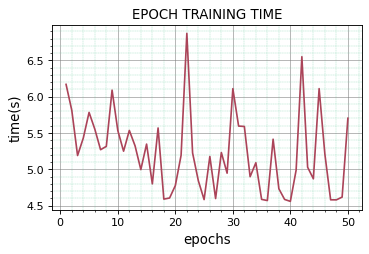

In [165]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color='#AB4459', label='ett')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Let's check the model's training and validation `mse` losses per epoch.

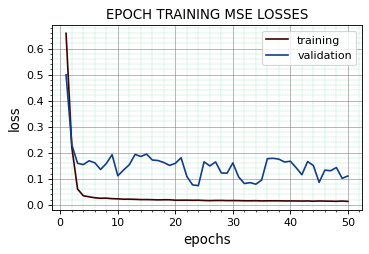

In [166]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#3D0301', label='training')
plt.plot(epochs, history.val_losses, color='#133E87', label='validation')
plt.title("EPOCH TRAINING MSE LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to load the best saved model and evaluate it on the `test` dataset.

In [169]:
model.load_state_dict(torch.load('bi-ltsm-model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'Test MSE Loss: {test_loss:.3f}')

Test MSE Loss: 0.087


### Model Inference

In this section we are going to make predictions using the best saved model that we have. 

In [176]:
def predict(model, X, device):
    with torch.no_grad():
        predictions = model(X.to(device)).to('cpu').numpy()
    pep_close, ko_close, pep_open, ko_open, pep_low, ko_low, pep_high, ko_high = (
        predictions[:, 0], predictions[:, 1],
        predictions[:, 2], predictions[:, 5],
        predictions[:, 4], predictions[:, 5],
        predictions[:, 6], predictions[:, 7],
    )
    return pep_close, ko_close, pep_open, ko_open, pep_low, ko_low, pep_high, ko_high
    
(
    train_pep_close_preds, 
    train_ko_close_preds, train_pep_open_preds, train_ko_open_preds,
    train_pep_low_preds, train_ko_low_preds, 
    train_pep_high_preds, train_ko_high_preds
) = predict(model, X_train, device)

(
    test_pep_close_preds, 
    test_ko_close_preds, test_pep_open_preds, test_ko_open_preds,
    test_pep_low_preds, test_ko_low_preds, 
    test_pep_high_preds, test_ko_high_preds
) = predict(model, X_test, device)

(
    val_pep_close_preds, 
    val_ko_close_preds, val_pep_open_preds, val_ko_open_preds,
    val_pep_low_preds, val_ko_low_preds, 
    val_pep_high_preds, val_ko_high_preds
) = predict(model, X_val, device)


Let's get all the actual values.

In [179]:
(
    train_pep_close_actuals, 
    train_ko_close_actuals, train_pep_open_actuals, train_ko_open_actuals,
    train_pep_low_actuals, train_ko_low_actuals, 
    train_pep_high_actuals, train_ko_high_actuals
) = y_train[:, 0], y_train[:, 1], y_train[:, 2], y_train[:, 3], y_train[:, 4], y_train[:, 5], y_train[:, 6], y_train[:, 7]

(
    test_pep_close_actuals, 
    test_ko_close_actuals, test_pep_open_actuals, test_ko_open_actuals,
    test_pep_low_actuals, test_ko_low_actuals, 
    test_pep_high_actuals, test_ko_high_actuals
) = y_test[:, 0], y_test[:, 1], y_test[:, 2], y_test[:, 3], y_test[:, 4], y_test[:, 5], y_test[:, 6], y_test[:, 7]

(
    val_pep_close_actuals, 
    val_ko_close_actuals, val_pep_open_actuals, val_ko_open_actuals,
    val_pep_low_actuals, val_ko_low_actuals, 
    val_pep_high_actuals, val_ko_high_actuals
) = y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5], y_val[:, 6], y_val[:, 7]


Next we are going to create the dataframe of prediction based on each set.

In [182]:

train_pred_df = pd.DataFrame(
    data={
      'pep_close': train_pep_close_actuals,
      'pep_close_pred':train_pep_close_preds,
      'ko_close': train_ko_close_actuals,
      'ko_close_pred':train_ko_close_preds,
      'ko_open': train_ko_open_actuals,
      'ko_open_pred':train_ko_open_preds,
      'pep_open': train_pep_open_actuals,
      'pep_open_pred':train_pep_open_preds,
      'ko_high': train_ko_high_actuals,
      'ko_high_pred':train_ko_high_preds,
      'ko_low': train_ko_low_actuals,
      'ko_low_pred':train_ko_low_preds,
      'pep_high': train_pep_high_actuals,
      'pep_high_pred':train_pep_high_preds,
      'pep_low': train_pep_low_actuals,
      'pep_low_pred':train_pep_low_preds,
    }
)
train_pred_df.head(2)

,pep_close,pep_close_pred,ko_close,ko_close_pred,ko_open,ko_open_pred,pep_open,pep_open_pred,ko_high,ko_high_pred,ko_low,ko_low_pred,pep_high,pep_high_pred,pep_low,pep_low_pred
0,-1.491655,-1.469355,1.268865,1.112185,1.129977,1.079408,-1.508805,-1.432494,1.224089,1.166620,1.162412,1.079408,-1.487222,-1.418355,-1.498705,-1.440929
1,-1.475070,-1.453938,1.326448,1.192861,1.281184,1.157535,-1.489529,-1.424080,1.316687,1.241385,1.249681,1.157535,-1.487222,-1.405759,-1.479364,-1.426282


In [184]:


test_pred_df = pd.DataFrame(
    data={
      'pep_close': test_pep_close_actuals,
      'pep_close_pred':test_pep_close_preds,
      'ko_close': test_ko_close_actuals,
      'ko_close_pred': test_ko_close_preds,
      'ko_open': test_ko_open_actuals,
      'ko_open_pred': test_ko_open_preds,
      'pep_open': test_pep_open_actuals,
      'pep_open_pred': test_pep_open_preds,
      'ko_high': test_ko_high_actuals,
      'ko_high_pred': test_ko_high_preds,
      'ko_low': test_ko_low_actuals,
      'ko_low_pred': test_ko_low_preds,
      'pep_high': test_pep_high_actuals,
      'pep_high_pred':test_pep_high_preds,
      'pep_low': test_pep_low_actuals,
      'pep_low_pred': test_pep_low_preds,
    }
)
test_pred_df.head(2)


,pep_close,pep_close_pred,ko_close,ko_close_pred,ko_open,ko_open_pred,pep_open,pep_open_pred,ko_high,ko_high_pred,ko_low,ko_low_pred,pep_high,pep_high_pred,pep_low,pep_low_pred
0,-0.471638,-0.40541,0.725297,0.653837,0.778334,0.665756,-0.129567,-0.364944,0.755925,0.668029,0.713320,0.665756,-0.255451,-0.376179,-0.467801,-0.381069
1,-0.469044,-0.39691,0.786295,0.708872,0.647100,0.719606,-0.629882,-0.359021,0.830262,0.720239,0.729394,0.719606,-0.585703,-0.367339,-0.514091,-0.371378


In [186]:
val_pred_df = pd.DataFrame(
    data={
      'pep_close': val_pep_close_actuals,
      'pep_close_pred': val_pep_close_preds,
      'ko_close': val_ko_close_actuals,
      'ko_close_pred': val_ko_close_preds,
      'ko_open': val_ko_open_actuals,
      'ko_open_pred': val_ko_open_preds,
      'pep_open': val_pep_open_actuals,
      'pep_open_pred': val_pep_open_preds,
      'ko_high': val_ko_high_actuals,
      'ko_high_pred': val_ko_high_preds,
      'ko_low': val_ko_low_actuals,
      'ko_low_pred': val_ko_low_preds,
      'pep_high': val_pep_high_actuals,
      'pep_high_pred': val_pep_high_preds,
      'pep_low': val_pep_low_actuals,
      'pep_low_pred': val_pep_low_preds,
    }
)
val_pred_df.head(2)

,pep_close,pep_close_pred,ko_close,ko_close_pred,ko_open,ko_open_pred,pep_open,pep_open_pred,ko_high,ko_high_pred,ko_low,ko_low_pred,pep_high,pep_high_pred,pep_low,pep_low_pred
0,-0.213938,-0.269721,1.068744,1.047366,1.077159,1.044006,-0.189836,-0.264224,1.064853,1.032379,1.121966,1.044006,-0.239678,-0.256315,-0.136240,-0.263571
1,-0.140893,-0.237285,1.106192,1.083546,1.058191,1.080628,-0.216582,-0.234686,1.061041,1.065714,1.123829,1.080628,-0.209599,-0.226464,-0.152928,-0.232719


We can see from our prediction that the values are still scaled. In the following code cell we are going to create a function called `postprocess_labels` which will take in the labels and inverse transform them to their actual values.

In [191]:
def postprocess_labels(arr, transformer):
  arr = transformer.inverse_transform(arr.reshape(-1, 1)).flatten()
  return arr

In the next code cell we are going to create a function called `plot_prediction` that will plot the predictions and returns us the 5 predictions in a dataframe.

In [194]:
def plot_predictions(dataframe, key, transform, title, maximum=150):
    _true = postprocess_labels(dataframe[key].values, pep_close_scaler)[:maximum]
    _preds =  postprocess_labels(dataframe[key+'_pred'].values, pep_close_scaler)[:maximum]
    plt.figure(figsize=(6, 3))
    plt.plot(_true, label='actual', color="#0D92F4")
    plt.plot(_preds, label='predicted', color="#F95454")
    plt.xlabel('Day', fontsize=10)
    plt.ylabel(key, fontsize=10)
    plt.legend(fontsize=8)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
    plt.title(title, fontsize=10)
    plt.show()
    train_preds_dataframe = pd.DataFrame({ "actuals": _true , "predicted": _preds})
    return train_preds_dataframe.head()

### Train Predictions

Next we are going to plot:

1. pep low
2. pep high
3. pep open
4. pep close
5. ko high
6. ko close
7. ko open
8. ko low

Using the train prediction dataframe.

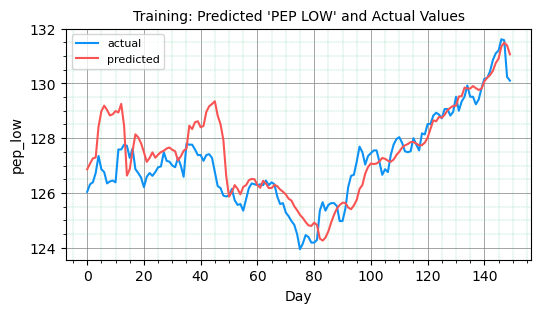

,actuals,predicted
0,126.037674,126.860283
1,126.313049,127.068817
2,126.384644,127.260406
3,126.726112,127.291641
4,127.348465,128.420670


In [197]:
plot_predictions(train_pred_df, 'pep_low', pep_low_scaler, title="Training: Predicted 'PEP LOW' and Actual Values")

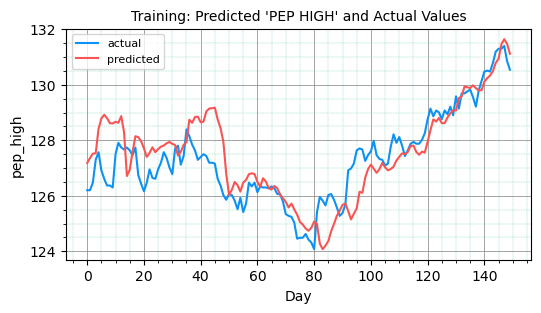

,actuals,predicted
0,126.201172,127.181679
1,126.201172,127.361023
2,126.474892,127.518372
3,127.296066,127.534294
4,127.569794,128.405655


In [199]:
plot_predictions(train_pred_df, 'pep_high', pep_high_scaler, title="Training: Predicted 'PEP HIGH' and Actual Values")

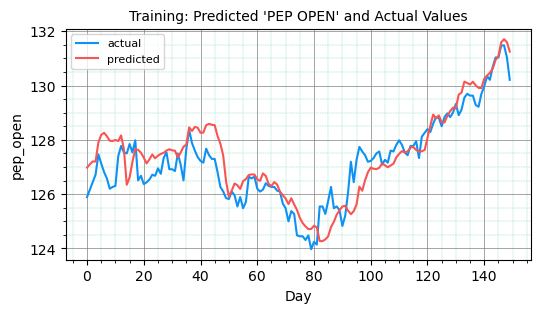

,actuals,predicted
0,125.893867,126.980370
1,126.168312,127.100159
2,126.442764,127.206963
3,126.717216,127.201668
4,127.469208,127.907326


In [201]:
plot_predictions(train_pred_df, 'pep_open', pep_open_scaler, title="Training: Predicted 'PEP OPEN' and Actual Values")

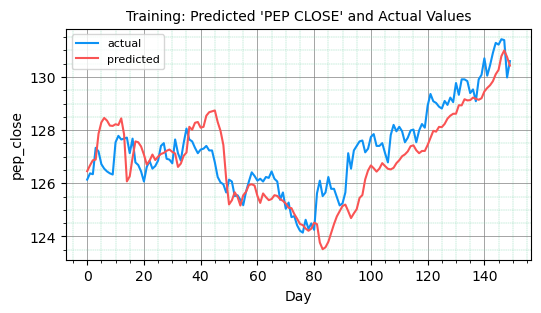

,actuals,predicted
0,126.138046,126.455544
1,126.374176,126.675056
2,126.341225,126.867599
3,127.335167,126.892769
4,127.197884,127.865860


In [202]:
plot_predictions(train_pred_df, 'pep_close', pep_close_scaler, title="Training: Predicted 'PEP CLOSE' and Actual Values")

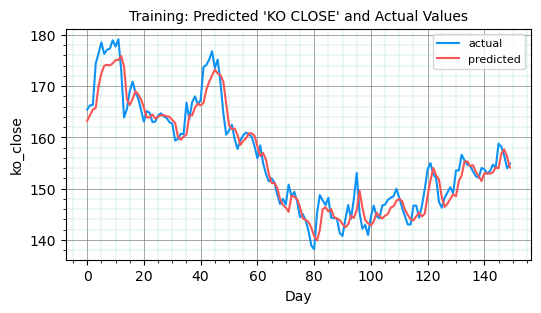

,actuals,predicted
0,165.441940,163.211151
1,166.261795,164.359802
2,166.360168,165.412659
3,174.361984,165.743912
4,176.411621,169.963043


In [205]:
plot_predictions(train_pred_df, 'ko_close', ko_close_scaler, title="Training: Predicted 'KO CLOSE' and Actual Values")

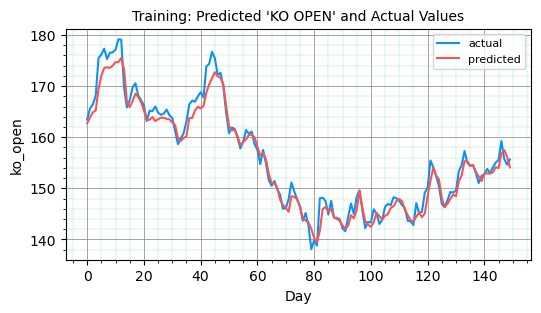

,actuals,predicted
0,163.464462,162.744476
1,165.617340,163.856827
2,166.439041,164.884964
3,168.082443,165.206497
4,175.477798,169.474411


In [207]:
plot_predictions(train_pred_df, 'ko_open', ko_open_scaler, title="Training: Predicted 'KO OPEN' and Actual Values")

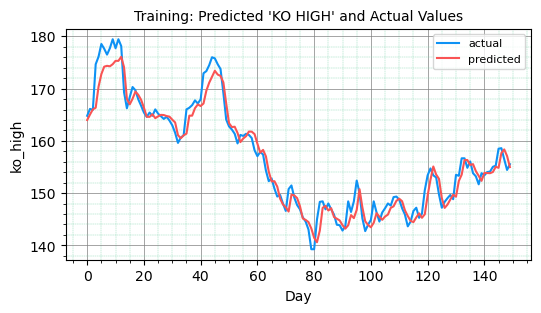

,actuals,predicted
0,164.804413,163.986176
1,166.122818,165.050674
2,165.927490,166.032242
3,174.667953,166.338730
4,176.100281,170.348694


In [209]:
plot_predictions(train_pred_df, 'ko_high', ko_high_scaler, title="Training: Predicted 'KO HIGH' and Actual Values")

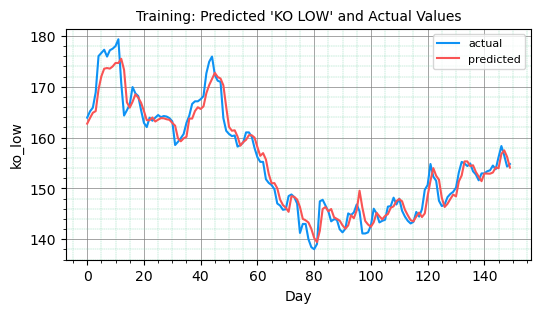

,actuals,predicted
0,163.926270,162.744476
1,165.168793,163.856827
2,165.897736,164.884964
3,168.896362,165.206497
4,176.036743,169.474411


In [211]:
plot_predictions(train_pred_df, 'ko_low', ko_low_scaler, title="Training: Predicted 'KO LOW' and Actual Values")

### Validation Predictions

Next we are going to plot:

1. pep low
2. pep high
3. pep open
4. pep close
5. ko high
6. ko close
7. ko open
8. ko low

Using the validation prediction dataframe.

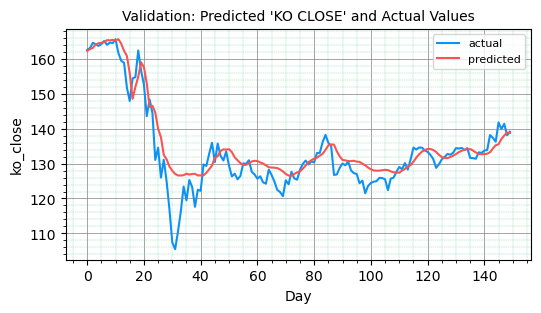

,actuals,predicted
0,162.592651,162.288269
1,163.125809,162.803375
2,164.618683,163.155197
3,164.192154,164.154953
4,163.712296,164.484924


In [214]:
plot_predictions(val_pred_df, 'ko_close', ko_close_scaler, title="Validation: Predicted 'KO CLOSE' and Actual Values")

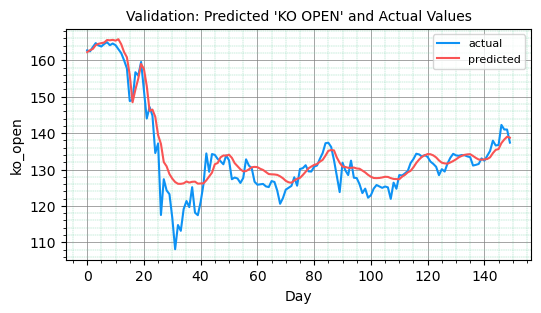

,actuals,predicted
0,162.712448,162.240417
1,162.442398,162.761841
2,163.630630,163.118790
3,164.710861,164.153717
4,164.062729,164.527328


In [216]:
plot_predictions(val_pred_df, 'ko_open', ko_open_scaler, title="Validation: Predicted 'KO OPEN' and Actual Values")

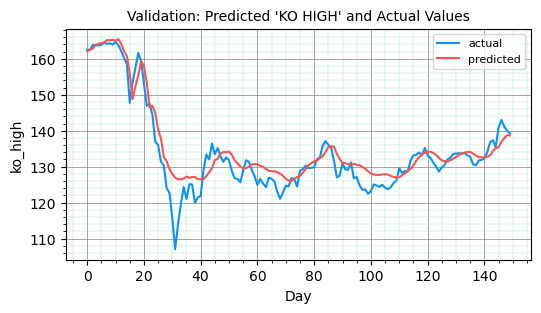

,actuals,predicted
0,162.537247,162.074875
1,162.482971,162.549500
2,163.894287,162.872772
3,163.785721,163.843262
4,163.704300,164.208862


In [218]:
plot_predictions(val_pred_df, 'ko_high', ko_high_scaler, title="Validation: Predicted 'KO HIGH' and Actual Values")

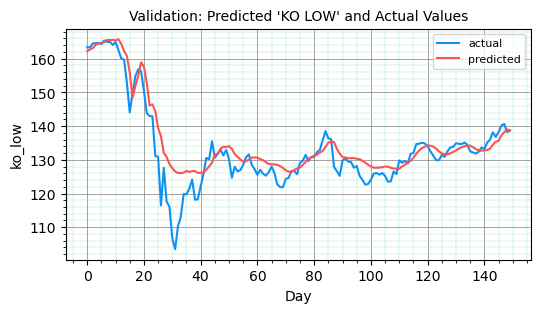

,actuals,predicted
0,163.350403,162.240417
1,163.376938,162.761841
2,164.544266,163.118790
3,164.623856,164.153717
4,164.623856,164.527328


In [220]:
plot_predictions(val_pred_df, 'ko_low', ko_low_scaler, title="Validation: Predicted 'KO LOW' and Actual Values")

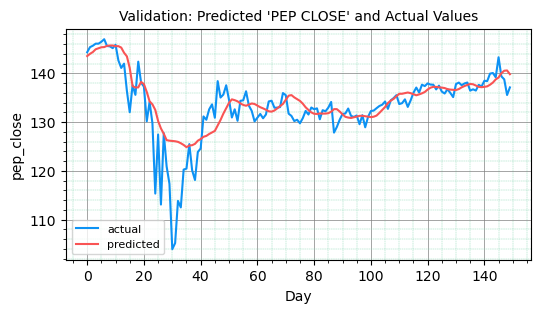

,actuals,predicted
0,144.330002,143.535767
1,145.369995,143.997589
2,145.660004,144.362076
3,146.080002,144.932724
4,146.080002,145.129517


In [222]:
plot_predictions(val_pred_df, 'pep_close', pep_close_scaler, title="Validation: Predicted 'PEP CLOSE' and Actual Values")

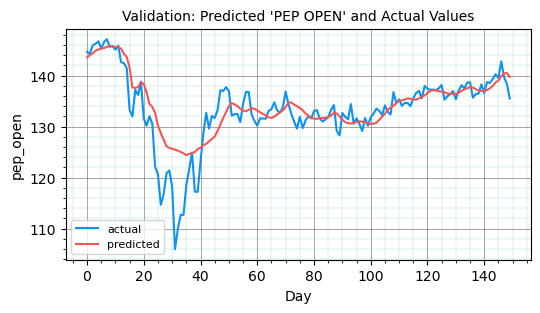

,actuals,predicted
0,144.673157,143.614029
1,144.292343,144.034592
2,145.965912,144.369293
3,146.246521,144.892822
4,146.717514,145.111679


In [224]:
plot_predictions(val_pred_df, 'pep_open', pep_open_scaler, title="Validation: Predicted 'PEP OPEN' and Actual Values")

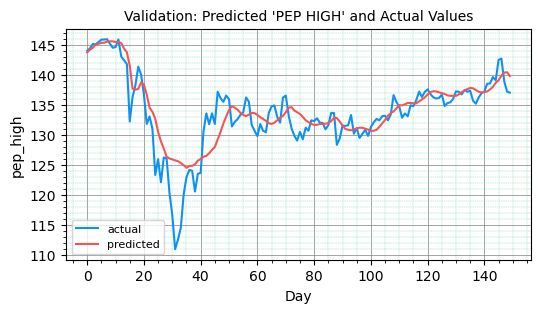

,actuals,predicted
0,143.963516,143.726639
1,144.391769,144.151642
2,145.105530,144.485840
3,145.044357,144.985794
4,145.431824,145.130066


In [226]:
plot_predictions(val_pred_df, 'pep_high', pep_high_scaler, title="Validation: Predicted 'PEP HIGH' and Actual Values")

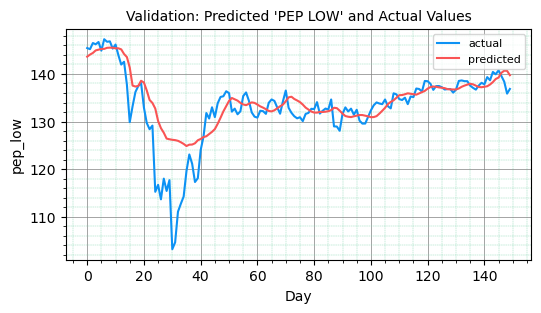

,actuals,predicted
0,145.436249,143.623322
1,145.198654,144.062607
2,146.485626,144.403595
3,146.228226,144.937027
4,146.703430,145.082016


In [228]:
plot_predictions(val_pred_df, 'pep_low', pep_low_scaler, title="Validation: Predicted 'PEP LOW' and Actual Values")

### Test Predictions

Next we are going to plot:

1. pep low
2. pep high
3. pep open
4. pep close
5. ko high
6. ko close
7. ko open
8. ko low

Using the test prediction dataframe.

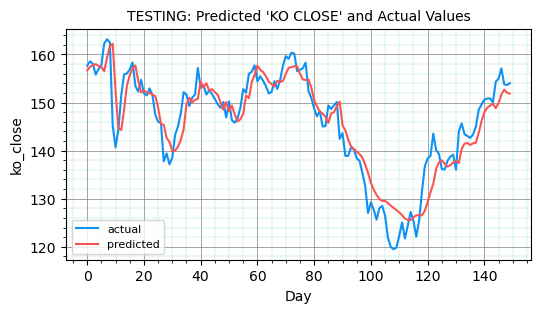

,actuals,predicted
0,157.702698,156.685242
1,158.571182,157.468826
2,158.080292,157.777481
3,155.814682,157.994461
4,156.947495,157.629578


In [233]:
plot_predictions(test_pred_df, 'ko_close', ko_close_scaler, title="TESTING: Predicted 'KO CLOSE' and Actual Values")

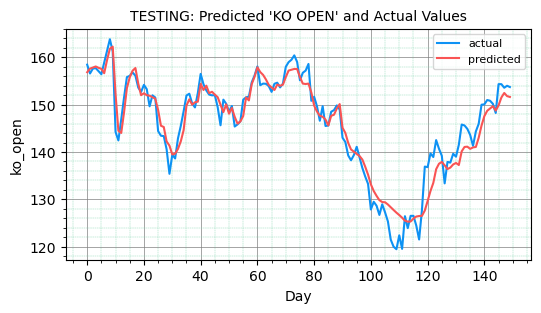

,actuals,predicted
0,158.457825,156.854950
1,156.589340,157.621674
2,157.618912,157.844910
3,157.733307,158.074844
4,157.085052,157.794128


In [235]:
plot_predictions(test_pred_df, 'ko_open', ko_open_scaler, title="TESTING: Predicted 'KO OPEN' and Actual Values")

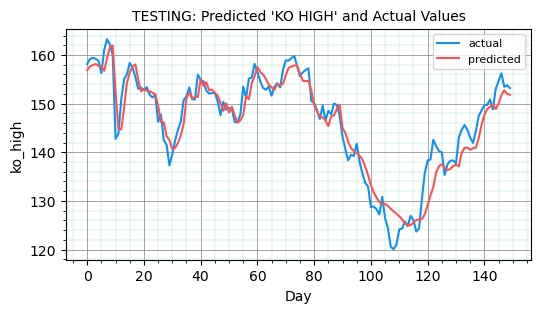

,actuals,predicted
0,158.138763,156.887314
1,159.197159,157.630661
2,159.405060,157.941467
3,159.234970,158.147491
4,158.781357,157.775223


In [237]:
plot_predictions(test_pred_df, 'ko_high', ko_high_scaler, title="TESTING: Predicted 'KO HIGH' and Actual Values")

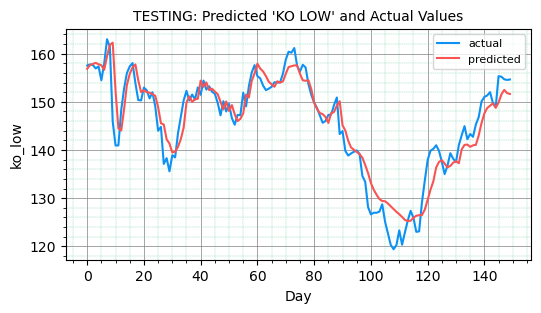

,actuals,predicted
0,157.532166,156.854950
1,157.761032,157.621674
2,157.646591,157.844910
3,156.921875,158.074844
4,157.341446,157.794128


In [239]:
plot_predictions(test_pred_df, 'ko_low', ko_low_scaler, title="TESTING: Predicted 'KO LOW' and Actual Values")

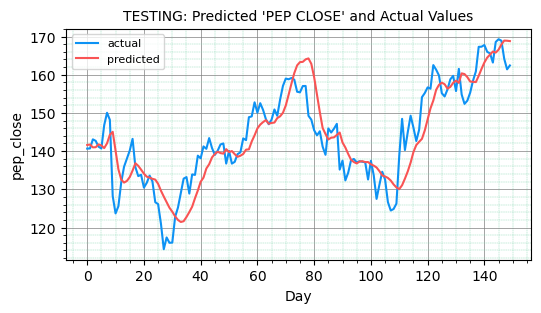

,actuals,predicted
0,140.660904,141.603851
1,140.697830,141.724869
2,143.079514,140.981964
3,142.691803,141.020309
4,141.159393,141.766754


In [240]:
plot_predictions(test_pred_df, 'pep_close', pep_close_scaler, title="TESTING: Predicted 'PEP CLOSE' and Actual Values")

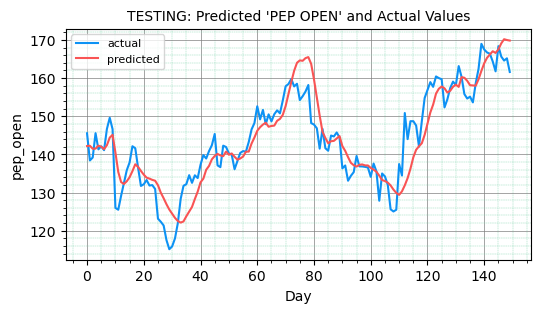

,actuals,predicted
0,145.531265,142.179993
1,138.407852,142.264328
2,139.182938,141.483627
3,145.568176,141.510147
4,141.323654,142.293884


In [241]:
plot_predictions(test_pred_df, 'pep_open', pep_open_scaler, title="TESTING: Predicted 'PEP OPEN' and Actual Values")

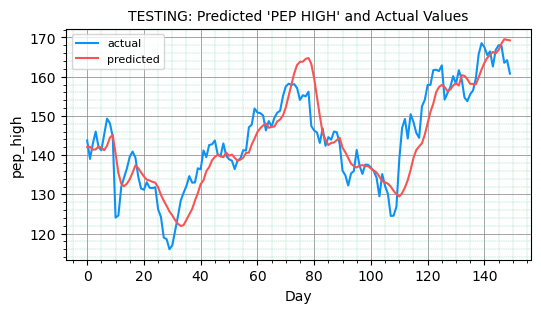

,actuals,predicted
0,143.738937,142.020020
1,139.036865,142.145889
2,142.927261,141.412094
3,146.015335,141.458771
4,142.040970,142.207733


In [242]:
plot_predictions(test_pred_df, 'pep_high', pep_high_scaler, title="TESTING: Predicted 'PEP HIGH' and Actual Values")

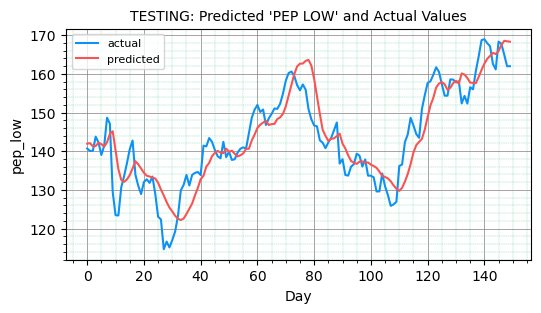

,actuals,predicted
0,140.715530,141.950409
1,140.056473,142.088394
2,140.129700,141.282288
3,143.772873,141.361801
4,142.253357,142.188019


In [243]:
plot_predictions(test_pred_df, 'pep_low', pep_low_scaler, title="TESTING: Predicted 'PEP LOW' and Actual Values")